In [1]:
### torch ###
import torch
import torchvision
import torch.nn.functional as F
import torch.utils.data 
from torch.autograd           import Variable
from torch                    import optim,nn
from torch.utils.data.sampler import BatchSampler,SequentialSampler
### nltk ###
from nltk.corpus   import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem     import WordNetLemmatizer 
from nltk          import FreqDist
### sklearn ###
from sklearn.metrics import confusion_matrix
from sklearn.utils   import shuffle
### matplotlib ###
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
### other ###
import seaborn as sns
import gensim
import io
import os
import pickle
import numpy  as np
import random
import time
import string
import pandas as pd
import math
%matplotlib inline  
############

train = './data/topicclass/topicclass_train.txt'
dev = './data/topicclass/topicclass_valid.txt'
test = './data/topicclass/topicclass_test.txt'
embedding_path ='./data/embedding/wiki-news-300d-1M.vec'
fdist_path = './data/procced/fdist_dict'
filtered_path = './data/procced/filtered_data'


In [2]:
### utils ###
def read_data(filename):
    classes = set()
    data = []
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    for line in lines:
        data.append(line.split('|||'))
    return data

def extract_classes(data):
    classes = set()
    for sample in data:
        classes = classes.union({sample[0]})
    return list(classes)

def get_dist(data):
    fdist = FreqDist(d[0] for d in data)
    return fdist

def split_data_by_classes(data):
    class2data = dict()
    for l,s in data:
        if l in class2data:
            class2data[l].append(s)
        else:
            class2data[l] = [s]
    return class2data

def get_most_common(data):
    all_words = np.hstack(np.array([clean_n_tokenize(d[1]) for d in data]))
    fdist = FreqDist(all_words)
    return fdist        

def get_most_common_from_sents(data,most_common = 100):
    all_words = np.hstack(np.array([clean_n_tokenize(d) for d in data]))
    fdist = FreqDist(all_words)
    return fdist.most_common(most_common)

def clean_n_tokenize(sent,most_common=None,soft_clean=True):
    lemmatizer = WordNetLemmatizer() 
    sent = word_tokenize(sent.lower())
    filtered_sent = []
    stop_words_punct = set(stopwords.words('english')).union(set(string.punctuation))
    for word in sent:
        word = lemmatizer.lemmatize(word)
        if word not in stop_words_punct:
            if most_common is not None:
                if word in most_common or (word.isdigit() and soft_clean):
                    filtered_sent.append(word)
            else:
                filtered_sent.append(word)
    return filtered_sent


def load_emb_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = map(float, tokens[1:])
    return data

Reading the data,line by line and spliting to lables and sentences.

### Exploration

In [3]:
train_data = read_data(train)
dev_data = read_data(dev)
test_data = read_data(test)
classes = extract_classes(train_data)
class2id = {i:classes[i] for i in range(len(classes))}

print("Train size {}".format(len(train_data)))
print("Dev size {}".format(len(dev_data)))
print("Test size {}".format(len(test_data)))
print("Classes size {}".format(len(classes)))
print("Classes {}".format(classes))

Train size 253909
Dev size 643
Test size 697
Classes size 16
Classes ['Language and literature ', 'Video games ', 'Natural sciences ', 'Social sciences and society ', 'Miscellaneous ', 'Agriculture, food and drink ', 'Engineering and technology ', 'Music ', 'Sports and recreation ', 'Geography and places ', 'Mathematics ', 'Warfare ', 'History ', 'Media and drama ', 'Philosophy and religion ', 'Art and architecture ']


Correcting type error in the dev.

In [4]:
new_dev_data = []
for l, s in dev_data:
    if l == 'Media and darama ':
        l = 'Media and drama '
    new_dev_data.append([[l],s])
dev_data = new_dev_data

In [5]:
classes_dist = get_dist(train_data)
class_dist_pd = pd.DataFrame({'dist':list(classes_dist.values())},
                             index=classes_dist.keys()).sort_values(by=["dist"],ascending=False)
class_dist_pd

,dist
Music,33761
Sports and recreation,31251
Natural sciences,29699
Warfare,26138
Media and drama,25420
Social sciences and society,20462
History,18427
Engineering and technology,18348
Geography and places,12239
Video games,11852


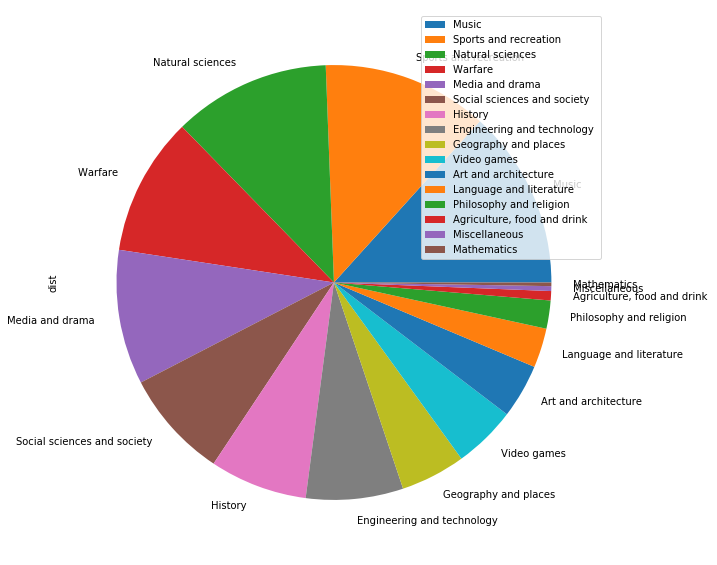

In [6]:
plot = class_dist_pd.plot.pie(y='dist', figsize=(10, 10))

We can see that the our dataset is not balanced, e.g Music with 33761 samples and in the otherside Mathematics with	679. But for most of the classes we have pretty much data to learn from.

Now, let's see the most common words for each class

In [7]:
class2data = split_data_by_classes(train_data)

In [ ]:
class2commons = dict()
for clas,sent in class2data.items():
    class2commons[clas] = get_most_common_from_sents(sent)

In [645]:
pd.DataFrame(class2commons)

,Social sciences and society,Sports and recreation,Natural sciences,Language and literature,Geography and places,Music,Media and drama,Art and architecture,Warfare,Engineering and technology,Video games,Philosophy and religion,"Agriculture, food and drink",History,Mathematics,Miscellaneous
0,"(wa, 6709)","(wa, 10699)","(wa, 5583)","(wa, 1966)","(wa, 2606)","(``, 21004)","(film, 8748)","(wa, 3552)","(wa, 12218)","(wa, 6975)","(game, 8238)","(wa, 1416)","(wa, 363)","(wa, 7853)","(number, 117)","(disease, 116)"
1,"('s, 3972)","(team, 5562)","(storm, 4535)","('s, 1784)","('s, 1747)","(wa, 11872)","(wa, 8041)","('s, 1774)","(war, 5291)","(route, 4949)","(wa, 4003)","(``, 1049)","('s, 329)","('s, 3583)","(``, 79)","(wa, 112)"
2,"(``, 3314)","('s, 5259)","(hurricane, 4227)","(``, 1717)","(city, 1570)","(album, 10735)","(``, 6299)","(building, 1390)","('s, 3430)","(highway, 4686)","('s, 2560)","('s, 868)","(``, 245)","(``, 1922)","(wa, 77)","(people, 85)"
3,"(state, 2299)","(season, 4547)","(tropical, 3936)","(book, 1222)","(ha, 1430)","(song, 9640)","('s, 5727)","(``, 1320)","(force, 3426)","(state, 4242)","(released, 1886)","(church, 472)","(ha, 190)","(–, 1405)","('s, 73)","(may, 83)"
4,"(united, 1354)","(league, 4123)","(cyclone, 2529)","(novel, 871)","(area, 1351)","('s, 8785)","(series, 2685)","(century, 1046)","(battle, 3033)","(u, 2322)","(series, 1565)","(also, 383)","(company, 167)","(king, 1267)","(mathematics, 65)","('s, 77)"
5,"(ha, 1288)","(first, 3952)","('s, 1910)","(series, 795)","(state, 1157)","(music, 5749)","(episode, 2326)","(church, 908)","(army, 2802)","(new, 1890)","(video, 1546)","(god, 334)","(food, 153)","(war, 1246)","(space, 61)","(symptom, 76)"
6,"(year, 1245)","(–, 3742)","(damage, 1895)","(ha, 682)","(park, 1029)","(single, 4344)","(first, 1817)","(ha, 793)","(british, 2149)","(ny, 1751)","(``, 1489)","(century, 304)","(product, 146)","(state, 1157)","(function, 60)","(cancer, 63)"
7,"(first, 1224)","(game, 3374)","(wind, 1866)","(story, 658)","(``, 1010)","(released, 4209)","(award, 1779)","(house, 782)","(``, 1969)","(road, 1711)","(player, 1366)","(ha, 272)","(restaurant, 126)","(year, 1142)","(group, 53)","(year, 59)"
8,"(school, 1224)","(``, 3184)","(season, 1768)","(published, 640)","(town, 1010)","(band, 3637)","(ha, 1670)","(art, 759)","(world, 1779)","(county, 1655)","(developed, 1104)","(known, 270)","(also, 101)","(first, 1028)","(one, 51)","(also, 56)"
9,"(court, 1064)","(football, 2947)","(``, 1736)","(first, 629)","(century, 986)","(number, 3036)","(american, 1595)","(one, 668)","(first, 1686)","(line, 1528)","(character, 1074)","(king, 266)","(new, 101)","(became, 938)","(graph, 51)","(``, 56)"


In [5]:
embd_model = gensim.models.KeyedVectors.load_word2vec_format(embedding_path)

In [6]:
if os.path.isfile(fdist_path): #is exist
    with open(fdist_path, 'rb') as f:
        fdist_dict = pickle.load(f)
else: fdist_words = get_most_common(train_data)
    
if os.path.isfile(filtered_path): #is exist
    with open(filtered_path, 'rb') as f:
        filtered_data = pickle.load(f)

Let's check words coverage in the embeddings

In [7]:
digits = set()
for cls,sent in filtered_data:
    digits = digits.union(set(filter(lambda w: w.isdigit(),sent)))
DIGITS_NUM = len(digits)

In [8]:
most_12_common = fdist_dict.most_common(12000)

In [49]:
coverage = 0
for w,_ in most_12_common:
    if w in embd_model.vocab:
        coverage += 1
print("Coverage {}% of the words by the embeding.".format(100*coverage/12000))

Coverage 97.25% of the words by the embeding.


Creating embedding matrix:

In [9]:
words = list(zip(*most_12_common))[0]
all_words_n_digits = set(words).union(digits)
embed_dict = dict()
for w in all_words_n_digits:
    if w in embd_model.vocab:
        embed_dict[w] = embd_model[w]
    else: 
        embed_dict[w] = np.random.uniform(-0.01, 0.01, 300).astype("float32")
VOCAB_SIZE = len(all_words_n_digits)

In [10]:
def filter_data(data,most_common):
    filtered = []
    for label,sent in data:
        filtered.append([label,clean_n_tokenize(sent,most_common)])
    return filtered

Now we will stay with the 12k commons words

In [20]:
# ##### no need to run again ######
# filtered_data = []
# i = 0
# size = 400
# while i <= len(train_data):
#     filtered_data += filter_data(train_data[i:i+size],most_12_common)
#     i = i + 400
    
# with open('filtered_data', 'wb') as f:
#     pickle.dump(filtered_data, f)

Also for the dev and test:

In [11]:
def clean_data(data):
    filtered_data = []
    most_common = list(map(lambda x:x[0],most_12_common))
    i = 0
    size = 400
    while i <= len(data):
        filtered_data += filter_data(data[i:i+size],most_common)
        i = i + 400
    return filtered_data

In [22]:
# no need to run
# filtered_dev_data = clean_data(dev_data)

Creating mapping from the most common 12k words to their embedding vector

Ive saved the filtered data after removing any word that not in the most common 12k, and the fdist.<br>
Here is the file loading:

In [12]:
sents_length = []
for label,sent in train_data:
    sents_length.append(len(sent.split()))
    
cleaned_sents_length = []
for label,sent in filtered_data:
    cleaned_sents_length.append(len(sent))

In [13]:
print("Mean sentences length {}".format(int(np.mean(sents_length))))
print("Max sentences length {}".format(np.max(sents_length)))
print("Min sentences length {}".format(np.min(sents_length)))
print("Cleaned sentences: ")
mean_sent_len = int(np.mean(cleaned_sents_length))
max_sent_len = int(np.max(cleaned_sents_length))
print("Mean sentences length {}".format(mean_sent_len))
print("Max sentences length {}".format(max_sent_len))
print("Min sentences length {}".format(np.min(cleaned_sents_length)))

Mean sentences length 26
Max sentences length 60
Min sentences length 5
Cleaned sentences: 
Mean sentences length 12
Max sentences length 39
Min sentences length 0


### Model

First, we will have to represent the sentences as one-hot inorder to feed the embedding layer and the nn.

In [14]:
def get_to_ix(training_data):
    to_ix = {}
    for tag, sent in training_data:
        for word in clean_n_tokenize(sent):
            if word not in to_ix:
                to_ix[word] = len(to_ix)
    return to_ix

def categoryFromOutput(output):
    # A tuple of (values, indices) is returned,
    # where the indices are the indices of the elements in the original input tensor.
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i]

def accuracy(real,pred):
    correct = 0
    N = 0
    for i in range(len(real)):
        for real_label,pred_label in zip(real[i],pred[i]):
            if real_label == categoryFromOutput(pred_label):
                    correct += 1
        N += len(real[i])
    return correct * 100 / N

def to_categorical(n,length):
    category = torch.zeros(length)
    category[int(n.data[0])] = 1
    return category.to('cuda')

In [15]:
word_to_ix = dict() # this must be in the embedding matrix weight order : first raw = first word.
for word in embed_dict.keys():
    if word not in word_to_ix:
        word_to_ix[word] = len(word_to_ix)
        
tag_to_ix = {val:idx for idx,val in enumerate(classes)}
word_to_ix_not_filtered = get_to_ix(train_data+dev_data)

Defining the model as simple LSTM:

In [ ]:
# These will usually be more like 32 or 64 dimensional.
# We will keep them small, so we can see how the weights change as we train.
EMBEDDING_DIM = 100
HIDDEN_DIM = mean_sent_len

In [ ]:
class LSTMClassifier(torch.nn.Module):
    def __init__(self,embedding_dim,hidden_dim,vocab_size,output_size,sent_length,pretrained=False):
        super(LSTMClassifier,self).__init__()
        
        if pretrained:
            embd_weight = torch.FloatTensor(pretrained)
            self.embeddings = nn.Embedding.from_pretrained(embd_weight,freeze=False)
            self.embedding_dim = 300

        else:
            self.embeddings = nn.Embedding(vocab_size, embedding_dim,padding_idx=0)
            self.embedding_dim = embedding_dim
            
        self.hidden_dim = hidden_dim
        self.hidden = Variable(torch.zeros(1, 1, self.hidden_dim)).cuda(),Variable(torch.zeros(1, 1, self.hidden_dim)).cuda()
        self.lstm = nn.LSTM(self.embedding_dim*sent_length,hidden_dim,num_layers=2)
        self.output = nn.Linear(hidden_dim,output_size)
        self.dropout = nn.Dropout(p=0.3)
        self.last_layer_bn = nn.BatchNorm1d(output_size)
        
    def forward(self,input_sent):
        x = self.embeddings(input_sent) # flatten
        x = x.view(len(input_sent),1,-1)
        x,self.hidden = self.lstm(x)
        x = x.contiguous()
        x = x.view(-1, x.shape[2])
        x = self.dropout(x)
        x = self.output(x)
        x = self.last_layer_bn(x)
        x = F.log_softmax(x,dim=1)
        return x
    
    def init_hidden(self):
        return Variable(torch.zeros(1, 1, self.hidden_dim)).cuda(),Variable(torch.zeros(1, 1, self.hidden_dim)).cuda()


### Training

In [16]:
def clean_n_tokenize_batch(batch,most_common = None,soft_clean=True):
    new_batch = []
    for label,sent in batch:
        new_batch.append([[label],clean_n_tokenize(sent,most_common,soft_clean)]) #format list of [[label],[w1,w2,..wn]] 
    return new_batch

def get_X_Y_from_batch(batch):
    labels = []
    sents = []
    for label,sent in batch:
        labels.append(label)
        sents.append(sent)
    return sents,labels

def prepare_batch(batch,to_ix, padding_len=None):
    new_batch = []
    for b in batch:
        new_batch.append(prepare_sequence(b,to_ix, padding_len))
    return torch.tensor(new_batch)

def prepare_sequence(seq, to_ix,padding_len=None):
    idxs = [to_ix[w] for w in seq]
    if padding_len is not None:
        if len(idxs) > padding_len:
            idxs = idxs[:padding_len]
        else:
            to_padd = padding_len - len(idxs)
            padd = [0]*to_padd
            idxs = idxs+padd
    return idxs

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [17]:
def plot_losses(losses,accuracy):
    plt.figure()
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.plot(losses)
    plt.plot(accuracy)
    plt.legend(('Train', 'Dev'),
           loc='upper right')
    plt.show()
    
def show_confusion_matrix(prediction,expected,classes):
    range_of_classes = range(len(classes))
    sns.heatmap(confusion_matrix(expected,prediction),cmap='Greens',annot=True, fmt='d')
    plt.xlabel('Prediction')
    plt.ylabel('True label')
    plt.title('Classification results on test set')
    plt.xticks(range_of_classes, classes, rotation=90)
    plt.yticks(range_of_classes, classes, rotation=0)
    sns.set(rc={'figure.figsize':(5,5)})    
    plt.show()
    
def batch_prediction(model,data,sent_length):
    X_i,Y_i = get_X_Y_from_batch(data)
    X_i = prepare_batch(X_i, word_to_ix, padding_len=sent_length).to('cuda')
    Y_i = torch.squeeze(prepare_batch(Y_i, tag_to_ix), 1).to('cuda')
    return model(X_i),Y_i
    
def accuracy_check(model,dev,sent_length):
    class_correct = list(0. for i in range(len(tag_to_ix)))
    class_total = list(0. for i in range(len(tag_to_ix)))
    with torch.no_grad():
        outputs,Y_i = batch_prediction(model,dev,sent_length)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == Y_i).squeeze().sum()
        return int(c)/int(len(dev)),(predicted,Y_i)
    
def round_lst(lst):
    return [round(float(l),3) for l in lst]

In [18]:
def train_model(model,train_data,dev,ephocs,batch_size,sent_length,word_to_ix,tag_to_ix,filtered = False,norm=None):
    all_losses = []
    dev_all_losses = []
    all_accuracy = []
    best_model_loss = 10000
    train_data = shuffle(train_data)
    train_batches_indcs = BatchSampler(SequentialSampler(train_data), batch_size=batch_size, drop_last=False)
    since = time.time()
    dev = clean_n_tokenize_batch(dev,most_common=list(embed_dict.keys()),soft_clean=False)
    dev = list(map(lambda lst:[lst[0][0],lst[1]],dev))
    print("--- start training ---")

    for epoch in range(ephocs):
        for indcs in train_batches_indcs:
            batch = train_data[indcs[0]:indcs[-1]]
            if not filtered:
                batch = clean_n_tokenize_batch(batch)  # tokenize and transform to cuda
            X_i, Y_i = get_X_Y_from_batch(batch)
            if filtered:
                Y_i = map(lambda x:[x],Y_i)

            model.zero_grad()
            # Also, we need to clear out the hidden state of the LSTM,
            # detaching it from its history on the last instance.
            model.hidden = model.init_hidden()

            # Step 2. Get our inputs ready for the network, that is, turn them into
            # Tensors of word indices.
            X_i = prepare_batch(X_i, word_to_ix, padding_len=sent_length).to('cuda')
            Y_i = torch.squeeze(prepare_batch(Y_i, tag_to_ix), 1).to('cuda')

            # Step 3. Run our forward pass.
            tag_scores = model(X_i)
            # Step 4. Compute the loss, gradients, and update the parameters by
            # calling optimizer.step()
            loss = loss_function(tag_scores, Y_i)  
            loss.backward()
            if norm is not None:
                nn.utils.clip_grad_norm_(norm['parameters'], max_norm=norm["norm_limit"])
            optimizer.step()
        
        dev_prediction,dev_Y_i = batch_prediction(model,dev,sent_length)
        dev_all_losses.append(loss_function(dev_prediction, dev_Y_i))  
        all_losses.append(float(loss))
        all_accuracy.append(accuracy_check(model,dev,sent_length)[0])
        print('Time: {} ephoc number: {} loss: {} dev loss: {} accuracy: {}'.format(timeSince(since),
                                                                                  epoch,
                                                                                  *round_lst([
                                                                                  all_losses[-1],
                                                                                  dev_all_losses[-1],
                                                                                  all_accuracy[-1]])))
        # save best model
        if dev_all_losses[-1] <= best_model_loss:
            best_model_loss = dev_all_losses[-1]
            torch.save(model.state_dict(), 'best_model')
        # early stopping with patience of 3 ephocs.
        if len(dev_all_losses) >=3 and (dev_all_losses[-3] <= dev_all_losses[-2] <= dev_all_losses[-1]):
            break
    model.load_state_dict(torch.load('best_model'))
    return model,all_losses,dev_all_losses,all_accuracy

In [97]:
HIDDEN_DIM = mean_sent_len
ephocs = 10

In [98]:
pretrained_model = LSTMClassifier(EMBEDDING_DIM,
                                  HIDDEN_DIM,
                                  len(word_to_ix), 
                                  len(tag_to_ix),
                                  sent_length=mean_sent_len,
                                  pretrained=list(embed_dict.values()))

pretrained_model = pretrained_model.cuda()
loss_function = nn.NLLLoss()
pretrianed_model_params = filter(lambda p: p.requires_grad,pretrained_model.parameters())
optimizer = optim.Adam(pretrianed_model_params)
print(pretrained_model)

LSTMClassifier(
  (embeddings): Embedding(12000, 300)
  (lstm): LSTM(3300, 11, num_layers=2)
  (output): Linear(in_features=11, out_features=16, bias=True)
  (dropout): Dropout(p=0.3)
  (last_layer_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


--- start training ---
Time: 1m 7s ephoc number: 0 loss: 1.487 dev loss: 1.42 accuracy: 0.694
Time: 2m 16s ephoc number: 1 loss: 1.045 dev loss: 1.091 accuracy: 0.72
Time: 3m 23s ephoc number: 2 loss: 0.856 dev loss: 0.993 accuracy: 0.731
Time: 4m 30s ephoc number: 3 loss: 0.645 dev loss: 0.995 accuracy: 0.742
Time: 5m 38s ephoc number: 4 loss: 0.575 dev loss: 1.081 accuracy: 0.712


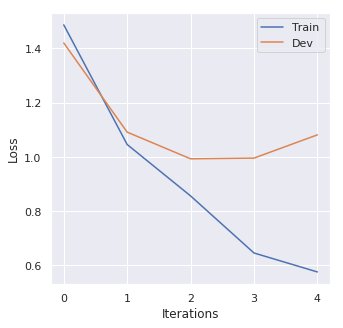

In [588]:
model,all_losses2,dev_all_losses2,acc2 = train_model(pretrained_model,
                                filtered_data,
                                new_dev_data,
                                ephocs,
                                batch_size,
                                mean_sent_len,
                                word_to_ix=word_to_ix, 
                                tag_to_ix=tag_to_ix, 
                                filtered = True)
plot_losses(all_losses2,dev_all_losses2)

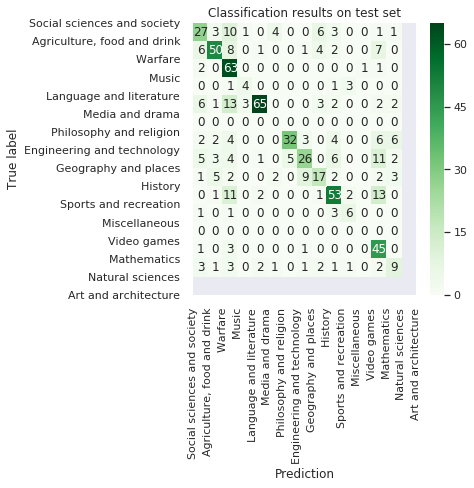

Best model among ephocs accuracy: 77.60000000000001 %


In [591]:
acc,(predictions,expected_Y_i) = accuracy_check(model,new_dev_data,mean_sent_len)
show_confusion_matrix(predictions,expected_Y_i,classes=list(tag_to_ix.keys()))
print("Best model among ephocs accuracy: {} %".format(round(float(acc),3) * 100))

In [ ]:
def split_data_by(data,class_name):
    without_data = []
    with_data = []
    for l,s in data:
        if l == class_name:
            with_data.append([l,s])
        else:
            without_data.append([l,s])
    return without_data,with_data

We can see that "Mathematics" and "Media and drama" were not predicted by the model at all.<br>
I'll try to train the model in two stages.At first, with new dataset which doesn't include these classes. <br>
In the second stage, i'll train the model only on these two small classes.<br>
Let's see what's happend.

In [595]:
without_math, with_math = split_data_by(filtered_data,'Mathematics ')
without_media__math,with_media = split_data_by(filtered_data,'Media and drama ')
print("with_media size {}".format(len(with_media)))
print("with_math size {}".format(len(with_math)))
print("without_media_math size {}".format(len(without_media_math)))

with_media size 25420
with_math size 679
without_media_math size 253230


In [601]:
new_model = LSTMClassifier(EMBEDDING_DIM,
                                  HIDDEN_DIM,
                                  len(word_to_ix), 
                                  len(tag_to_ix),
                                  sent_length=mean_sent_len,
                                  pretrained=list(embed_dict.values()))

new_model = new_model.cuda()
loss_function = nn.NLLLoss()
optimizer = optim.Adam(new_model.parameters())
print(new_model)

LSTMClassifier(
  (embeddings): Embedding(12000, 300)
  (lstm): LSTM(3600, 12, num_layers=2)
  (output): Linear(in_features=12, out_features=16, bias=True)
  (dropout): Dropout(p=0.3)
  (last_layer_bn): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


--- start training ---
Time: 1m 6s ephoc number: 0 loss: 1.411 dev loss: 1.368 accuracy: 0.708
Time: 2m 12s ephoc number: 1 loss: 0.981 dev loss: 1.085 accuracy: 0.723
Time: 3m 18s ephoc number: 2 loss: 0.734 dev loss: 1.054 accuracy: 0.751
Time: 4m 24s ephoc number: 3 loss: 0.542 dev loss: 1.054 accuracy: 0.739
Time: 5m 31s ephoc number: 4 loss: 0.413 dev loss: 1.086 accuracy: 0.729


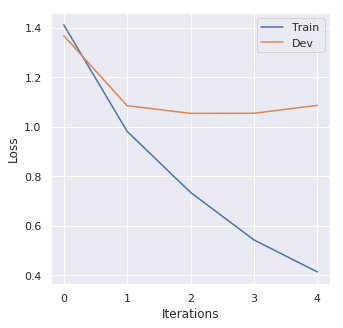

In [602]:
new_model,all_losses,dev_all_losses,acc = train_model(new_model,
                                without_math, # <----------- that's the change
                                new_dev_data,
                                ephocs,
                                batch_size,
                                mean_sent_len,
                                word_to_ix=word_to_ix, 
                                tag_to_ix=tag_to_ix, 
                                filtered = True)
plot_losses(all_losses,dev_all_losses)

I'll use the best model from the first stage.

--- start training ---
Time: 0m 0s ephoc number: 0 loss: 4.853 dev loss: 1.022 accuracy: 0.739
Time: 0m 0s ephoc number: 1 loss: 4.793 dev loss: 1.029 accuracy: 0.743
Time: 0m 0s ephoc number: 2 loss: 4.75 dev loss: 1.051 accuracy: 0.76


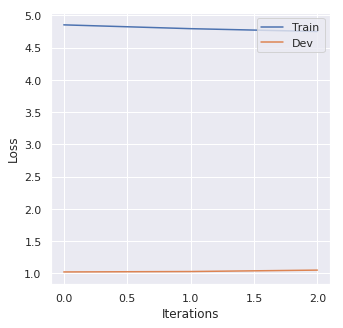

In [603]:
model,all_losses2,dev_all_losses2,acc2 = train_model(new_model,
                                with_math, # <----------- that's the change
                                new_dev_data,
                                ephocs,
                                batch_size,
                                mean_sent_len,
                                word_to_ix=word_to_ix, 
                                tag_to_ix=tag_to_ix, 
                                filtered = True)
plot_losses(all_losses2,dev_all_losses2)

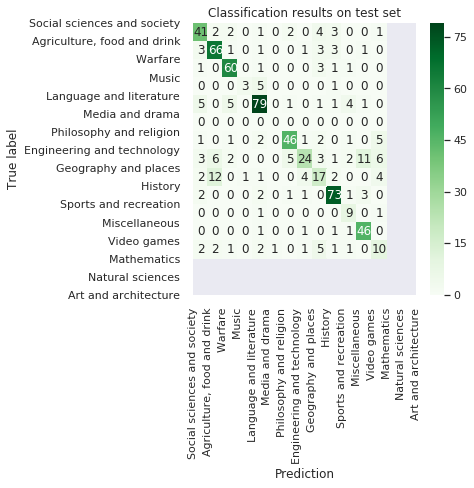

Best model among ephocs accuracy: 73.7 %


In [604]:
acc,(predictions,expected_Y_i) = accuracy_check(model,new_dev_data,mean_sent_len)
show_confusion_matrix(predictions,expected_Y_i,classes=list(tag_to_ix.keys()))
print("Best model among ephocs accuracy: {} %".format(round(float(acc),3) * 100))

--- start training ---
Time: 0m 0s ephoc number: 0 loss: 4.831 dev loss: 1.026 accuracy: 0.742


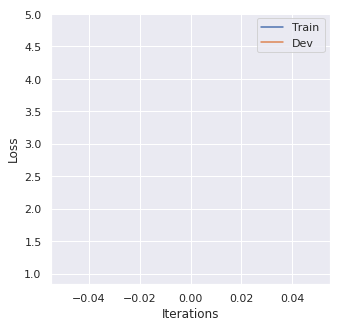

In [606]:
ephocs = 1 # <----------- that's the change
model,all_losses2,dev_all_losses2,acc2 = train_model(new_model,
                                with_math, 
                                new_dev_data,
                                ephocs,
                                batch_size,
                                mean_sent_len,
                                word_to_ix=word_to_ix, 
                                tag_to_ix=tag_to_ix, 
                                filtered = True)
plot_losses(all_losses2,dev_all_losses2)

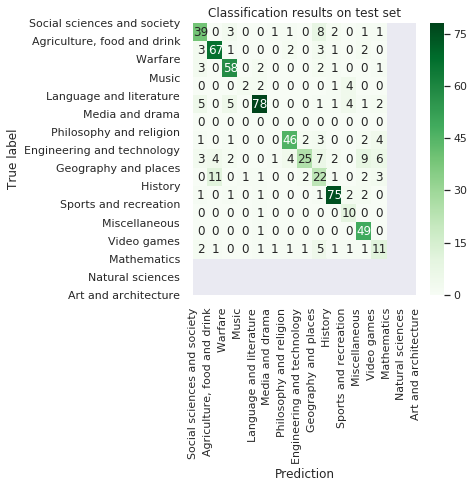

Best model among ephocs accuracy: 75.0 %


In [607]:
acc,(predictions,expected_Y_i) = accuracy_check(model,new_dev_data,mean_sent_len)
show_confusion_matrix(predictions,expected_Y_i,classes=list(tag_to_ix.keys()))
print("Best model among ephocs accuracy: {} %".format(round(float(acc),3) * 100))

Ok, we can see for improvment in the Mathematics raw, from 0 predictions to 10 !<br>
Let's see the different between lstm and cnn for classification task.

In [28]:
class CNNClassifier(torch.nn.Module):

    def __init__(self, batch_size,max_sent_len,word_dim,vocab_size,class_size,filters,filter_num,dropout,embd_matrix):
        super(CNNClassifier, self).__init__()

        self.batch_size = batch_size
        self.max_sent_len = max_sent_len
        self.word_dim = word_dim
        self.vocab_size = vocab_size
        self.class_size = class_size
        self.filters = filters
        self.filter_num = filter_num
        self.dropout = dropout
        self.in_channel = 2

        self.embd_matrix = torch.FloatTensor(embd_matrix)
        self.static_embedding = nn.Embedding.from_pretrained(self.embd_matrix,freeze=True) #If ``True``, the tensor does not get updated
        self.non_stat_embedding = nn.Embedding.from_pretrained(self.embd_matrix,freeze=False)
        
        for i in range(len(self.filters)):
            conv = nn.Conv1d(self.in_channel, self.filter_num[i], self.word_dim * self.filters[i], stride=self.word_dim)
            setattr(self, f'conv_{i}', conv)
            
        self.fc = nn.Linear(sum(self.filter_num), self.class_size)

        
    def get_conv(self, i):
        return getattr(self, f'conv_{i}')
    
    def forward(self, inp):
        x1 = self.non_stat_embedding(inp).view(-1, 1, self.word_dim * self.max_sent_len)
        
        x2 = self.static_embedding(inp).view(-1, 1, self.word_dim * self.max_sent_len)
        
        x = torch.cat((x1, x2), 1)

        conv_results = [
            F.max_pool1d(F.relu(self.get_conv(i)(x)), self.max_sent_len - self.filters[i] + 1)
                .view(-1, self.filter_num[i])
            for i in range(len(self.filters))]

        x = torch.cat(conv_results, 1)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc(x)

        return x
    
    def init_hidden(self): # model training method interface requirement.
        pass 


In [20]:
model = CNNClassifier(batch_size=50,
                      max_sent_len=20,
                      word_dim=300,
                      vocab_size=len(word_to_ix),
                      class_size=len(class2id),
                      filters=[3, 4, 5],
                      filter_num=[100, 100, 100],
                      dropout=0.5,
                      embd_matrix=list(embed_dict.values()))

model = model.cuda()
loss_function = nn.CrossEntropyLoss()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.Adadelta(parameters)
print(model)

CNNClassifier(
  (static_embedding): Embedding(13840, 300)
  (non_stat_embedding): Embedding(13840, 300)
  (conv_0): Conv1d(2, 100, kernel_size=(900,), stride=(300,))
  (conv_1): Conv1d(2, 100, kernel_size=(1200,), stride=(300,))
  (conv_2): Conv1d(2, 100, kernel_size=(1500,), stride=(300,))
  (fc): Linear(in_features=300, out_features=16, bias=True)
)


In [21]:
ephocs = 3
batch_size = 50

--- start training ---
Time: 7m 28s ephoc number: 0 loss: 2.494 dev loss: 0.833 accuracy: 0.767
Time: 14m 17s ephoc number: 1 loss: 1.9 dev loss: 0.866 accuracy: 0.773
Time: 20m 59s ephoc number: 2 loss: 1.411 dev loss: 0.928 accuracy: 0.765


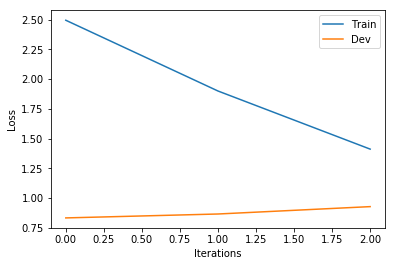

In [22]:
norm = {'parameters':parameters,'norm_limit':3}
model,all_losses,dev_all_losses,acc = train_model(model,
                                filtered_data,
                                new_dev_data,
                                ephocs,
                                batch_size,
                                sent_length=20,
                                word_to_ix=word_to_ix, 
                                tag_to_ix=tag_to_ix, 
                                filtered = True,
                                norm=norm)
plot_losses(all_losses,dev_all_losses)

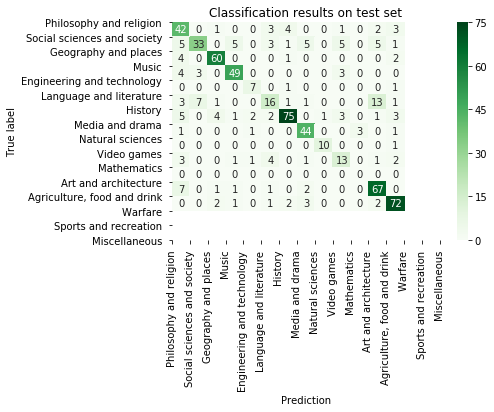

Best model among ephocs accuracy: 75.9 %


In [23]:
dev = clean_n_tokenize_batch(new_dev_data,most_common=list(zip(*most_12_common))[0],soft_clean=False)
dev = list(map(lambda lst:[lst[0][0],lst[1]],dev))
acc,(predictions,expected_Y_i) = accuracy_check(model,dev,20)
show_confusion_matrix(predictions,expected_Y_i,classes=list(tag_to_ix.keys()))
print("Best model among ephocs accuracy: {} %".format(round(float(acc),3) * 100))

I'll try to increase the batch size from 50 to 1028 and see what happend.

In [29]:
model = CNNClassifier(batch_size=1028,
                      max_sent_len=20,
                      word_dim=300,
                      vocab_size=len(word_to_ix),
                      class_size=len(class2id),
                      filters=[3, 4, 5],
                      filter_num=[100, 100, 100],
                      dropout=0.5,
                      embd_matrix=list(embed_dict.values()))

model = model.cuda()
loss_function = nn.CrossEntropyLoss()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.Adadelta(parameters)
print(model)

CNNClassifier(
  (static_embedding): Embedding(13840, 300)
  (non_stat_embedding): Embedding(13840, 300)
  (conv_0): Conv1d(2, 100, kernel_size=(900,), stride=(300,))
  (conv_1): Conv1d(2, 100, kernel_size=(1200,), stride=(300,))
  (conv_2): Conv1d(2, 100, kernel_size=(1500,), stride=(300,))
  (fc): Linear(in_features=300, out_features=16, bias=True)
)


--- start training ---
Time: 3m 20s ephoc number: 0 loss: 1.108 dev loss: 0.844 accuracy: 0.747
Time: 6m 37s ephoc number: 1 loss: 0.974 dev loss: 0.777 accuracy: 0.779
Time: 9m 57s ephoc number: 2 loss: 0.94 dev loss: 0.77 accuracy: 0.785


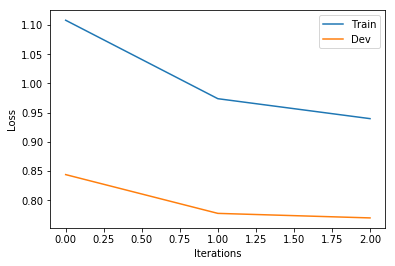

In [30]:
norm = {'parameters':parameters,'norm_limit':3}
model,all_losses,dev_all_losses,acc = train_model(model,
                                filtered_data,
                                new_dev_data,
                                3,
                                1028,
                                sent_length=20,
                                word_to_ix=word_to_ix, 
                                tag_to_ix=tag_to_ix, 
                                filtered = True,
                                norm=norm)
plot_losses(all_losses,dev_all_losses)

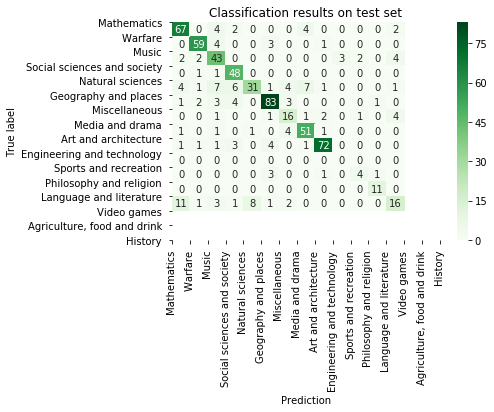

Best model among ephocs accuracy: 77.9 %


In [31]:
dev = clean_n_tokenize_batch(new_dev_data,most_common=list(zip(*most_12_common))[0],soft_clean=False)
dev = list(map(lambda lst:[lst[0][0],lst[1]],dev))
acc,(predictions,expected_Y_i) = accuracy_check(model,dev,20)
show_confusion_matrix(predictions,expected_Y_i,classes=list(tag_to_ix.keys()))
print("Best model among ephocs accuracy: {} %".format(round(float(acc),3) * 100))

Based on : https://www.aclweb.org/anthology/D14-1181.pdf

In [21]:
class CNNClassifier2(torch.nn.Module):

    def __init__(self, batch_size,max_sent_len,word_dim,vocab_size,class_size,filters,filter_num,dropout,embd_matrix):
        super(CNNClassifier2, self).__init__()

        self.batch_size = batch_size
        self.max_sent_len = max_sent_len
        self.word_dim = word_dim
        self.vocab_size = vocab_size
        self.class_size = class_size
        self.filters = filters
        self.filter_num = filter_num # feature maps 
        self.dropout = dropout
        self.in_channel = 2

        self.embd_matrix = torch.FloatTensor(embd_matrix)
        self.static_embedding = nn.Embedding.from_pretrained(self.embd_matrix,freeze=True) #If ``True``, the tensor does not get updated
        self.non_stat_embedding = nn.Embedding.from_pretrained(self.embd_matrix,freeze=False)
        
        for i in range(len(self.filters)):
            #(in_channels, out_channels, kernel_size...)
            conv = nn.Conv1d(self.in_channel, self.filter_num[i], self.word_dim * self.filters[i], stride=self.word_dim)
            setattr(self, f'conv_{i}', conv)
            
        self.fc1 = nn.Linear(sum(self.filter_num), 128)
        self.fc2 = nn.Linear(128, self.class_size)

        
    def get_conv(self, i):
        return getattr(self, f'conv_{i}')
    
    def forward(self, inp):
        x1 = self.non_stat_embedding(inp).view(-1, 1, self.word_dim * self.max_sent_len)
        
        x2 = self.static_embedding(inp).view(-1, 1, self.word_dim * self.max_sent_len)
        
        x = torch.cat((x1, x2), 1)

        conv_results = [
            F.max_pool1d(F.relu(self.get_conv(i)(x)), self.max_sent_len - self.filters[i] + 1)
                .view(-1, self.filter_num[i])
            for i in range(len(self.filters))]

        x = torch.cat(conv_results, 1)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc1(x)
        x = F.relu(F.dropout(x, p=self.dropout, training=self.training))
        x = self.fc2(x)

        return x
    
    def init_hidden(self): # model training method interface requirement.
        pass 


CNNClassifier2(
  (static_embedding): Embedding(13840, 300)
  (non_stat_embedding): Embedding(13840, 300)
  (conv_0): Conv1d(2, 100, kernel_size=(900,), stride=(300,))
  (conv_1): Conv1d(2, 100, kernel_size=(1200,), stride=(300,))
  (conv_2): Conv1d(2, 100, kernel_size=(1500,), stride=(300,))
  (fc1): Linear(in_features=300, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=16, bias=True)
)
--- start training ---
Time: 5m 17s ephoc number: 0 loss: 1.127 dev loss: 0.966 accuracy: 0.714
Time: 11m 29s ephoc number: 1 loss: 0.994 dev loss: 0.814 accuracy: 0.759
Time: 17m 38s ephoc number: 2 loss: 0.936 dev loss: 0.796 accuracy: 0.788


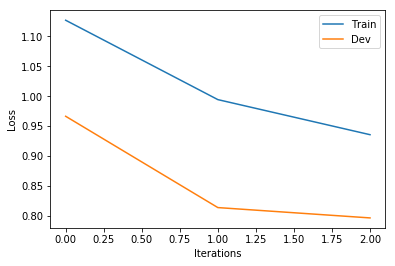

In [22]:
model = CNNClassifier2(batch_size=2048,
                      max_sent_len=20,
                      word_dim=300,
                      vocab_size=len(word_to_ix),
                      class_size=len(class2id),
                      filters=[3, 4, 5],
                      filter_num=[100, 100, 100],
                      dropout=0.5,
                      embd_matrix=list(embed_dict.values()))

model = model.cuda()
loss_function = nn.CrossEntropyLoss()
parameters = filter(lambda p: p.requires_grad, model.parameters())
optimizer = optim.Adadelta(parameters)
print(model)

norm = {'parameters':parameters,'norm_limit':3}
model,all_losses,dev_all_losses,acc = train_model(model,
                                filtered_data,
                                new_dev_data,
                                3,
                                1028,
                                sent_length=20,
                                word_to_ix=word_to_ix, 
                                tag_to_ix=tag_to_ix, 
                                filtered = True,
                                norm=norm)
plot_losses(all_losses,dev_all_losses)

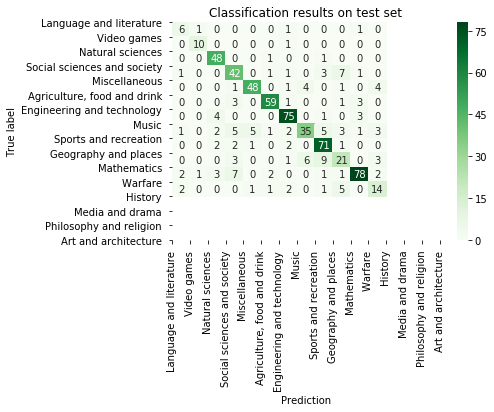

Best model among ephocs accuracy: 78.8 %


In [23]:
dev = clean_n_tokenize_batch(new_dev_data,most_common=list(zip(*most_12_common))[0],soft_clean=False)
dev = list(map(lambda lst:[lst[0][0],lst[1]],dev))
acc,(predictions,expected_Y_i) = accuracy_check(model,dev,20)
show_confusion_matrix(predictions,expected_Y_i,classes=list(tag_to_ix.keys()))
print("Best model among ephocs accuracy: {} %".format(round(float(acc),3) * 100))